- Load files and visualize car/noncar
- `findcars()`
    - HOG: `hog_generator(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)`. **Can also implement SIFT features**
    - `extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)`
        - Convert img to a color space
        - For each channel of the color space, 'R', 'G', 'B' or 'H', 'S', 'V'. Get the hog features for that particular channel `img[:, :, channel]` then stack all vectors together
    - Standard Scaler
    - Train/test split
    - Fit SVC on train set. Evaluate on test set.
    - Write the final `find_cars()` function
        - ystart, ystop : threshold
        - colorspace, hog_channel : can be RGB, HSV. Choose YUV. Determine which feature to stack
        - scale : for scaling the window
        - svc: classifier after training
- Test the `find_cars()` function on a few images with different test images. Also test with random images found on the internet?
- `draw_boxes(np.copy(frame), rectangles_coors)` : draw on an image. Always make copy.
- `heatmap()`
- `draw_cars(np.copy(frame), heatmap_labels)` : take in `heatmap_labels = (num_cars, labeled_array)`. Have to get nonzero coordinates based on the car index. Draw boxes based on the coordinates  

For my process_frame function (without history)
- `find_cars(frame, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)` to return `bboxes` : given the ystart, ystop boundaries, find all the bboxes with cars in them
- `heatmap(canvas, bboxes, threshold)` to return `rectangles_coors` : from the bounding boxes, generate heatmap of binary code so that we can use the `scipy.ndimage.measurements.label` to collapse all tiny boxes with cars in them into large regions. Also apply **threshold** to filter out for weak signals
- `draw_label_boxes(np.copy(frame), rectangles_coors)` : draw final bounding boxes on the video

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

Link to Pickle files: https://www.dropbox.com/s/rfl7h55k6bb26xr/car_dataset.p?dl=0

## Import & Visualize

In [2]:
car_dataset = pickle.load(open("car_dataset.p", "rb"))
cars, notcars = np.asarray(car_dataset['car']), np.asarray(car_dataset['noncar'])

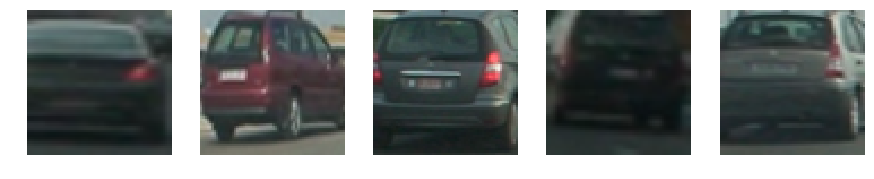

In [3]:
plt.figure(figsize=(15,15))
for i, img in enumerate(cars[np.random.randint(len(cars), size=5)]):   
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

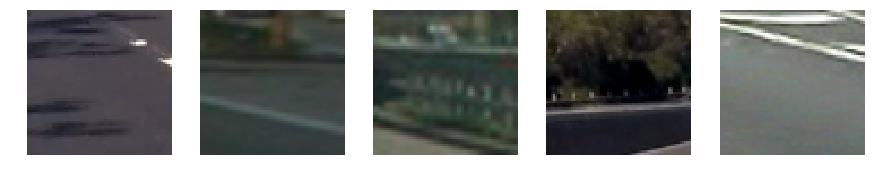

In [4]:
plt.figure(figsize=(15,15))
for i, img in enumerate(notcars[np.random.randint(len(cars), size=5)]):   
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# 1. Train a car classifier 

### HOG Features

In [5]:
from skimage.feature import hog
def get_hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), vis=False):
    """Extract HOG features from a channel
    
    skimage.feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), 
    block_norm=None, visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
    
    out : (n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient) ndarray
    HOG descriptor for the image. If feature_vector is True, a 1D (flattened) array is returned.

    hog_image : (M, N) ndarray, optional
    A visualisation of the HOG image. Only provided if visualize is True.
    """
    if vis:
        hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualise=vis)
        plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.show()
        return hog_features
    else:
        return hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    
def dense_SIFT(image, density=0.05, display=False):
    """Generate dense SIFT descriptors
    Args:
        image: A numpy array representing the image, which is of type np.int in range [0, 255] of size
            (H x W x 3) in RGB order (eg. output of cv2.imread).
        density: Decide the density of the descriptors.

    Returns:
      result: A one level 128-dimension list with the mean description value of total descriptors.
    """
    # Convert into gray pic
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    # Generate a sift to calculate description vector later
    sift = cv2.xfeatures2d.SIFT_create()

    # The step to evenly pick the description point
    # Use the short side len multiply density
    step_size = round(min(image.shape[0], image.shape[1]) * density)

    # Calculate the points with step_size
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
          for x in range(0, gray.shape[1], step_size)]

    # Calculate the description vector for each points
    dense_feat = sift.compute(gray, kp)

    # Without flattening
    # return dense_feat[1]
    
    if display:
        cv2.drawKeypoints(gray, kp, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure()
        plt.imshow(image[:, :, ::-1])
        plt.show()

    # Flatten the n description vectors, n for the num of description points
    return np.mean(dense_feat[1], axis=0)

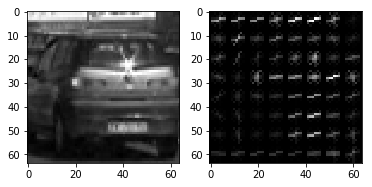

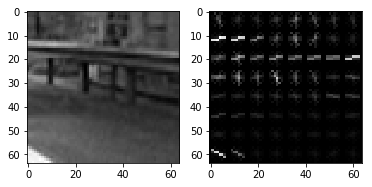

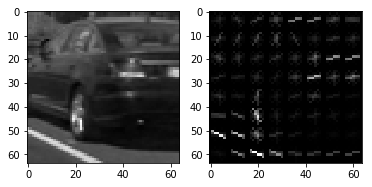

In [6]:
# Red Channel
_ = get_hog(cars[100][:,:,0], vis=True)
# Blue Channel
_ = get_hog(notcars[200][:,:,1], vis=True)
# Green Channel
_ = get_hog(cars[300][:,:,2], vis=True)

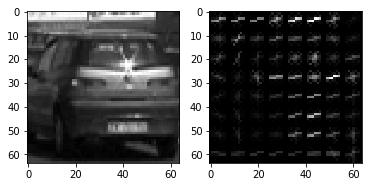

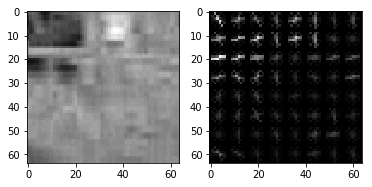

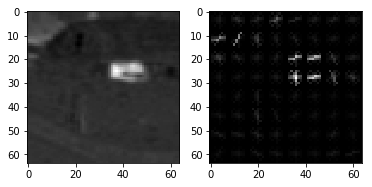

In [7]:
# Y Channel
_ = get_hog(cv2.cvtColor(cars[100], cv2.COLOR_RGB2YUV)[:,:,0], vis=True)
# U Channel
_ = get_hog(cv2.cvtColor(notcars[200], cv2.COLOR_RGB2YUV)[:,:,1], vis=True)
# V Channel
_ = get_hog(cv2.cvtColor(cars[300], cv2.COLOR_RGB2YUV)[:,:,2], vis=True)

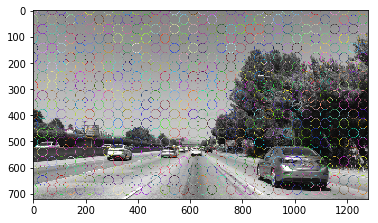

(128,)


In [8]:
sift_f = dense_SIFT(cv2.imread("bbox-example-image.jpg"), display=True)
print(sift_f.shape)

### Extract features pipeline for all images in the dataset

In [9]:
def extract_features(data, method='HOG', cspace='RGB', orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), hog_channel='ALL'):
    """ Extract features for the dataset. Default is HOG.
    
    Returns: numpy array of (len(data), len(features)).
    """
    
    features = []
    # Loop through all images
    for image in data:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if method == 'HOG':
            hog_features = []
            if hog_channel == 'ALL':     
                # For-loop through all channel
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog(feature_image[:,:,channel], orientations=orientations, 
                                                              pixels_per_cell=pixels_per_cell, 
                                                              cells_per_block=cells_per_block))
                hog_features = np.ravel(hog_features) # Make 3 sub-channel features, into 1 single array       
            else:
                hog_features = get_hog(feature_image[:,:,hog_channel], orientations=orientations, 
                                                              pixels_per_cell=pixels_per_cell, 
                                                              cells_per_block=cells_per_block)
            # Append the new feature vector to the features list
            features.append(hog_features)

        if method == 'SIFT':
            sift_features = dense_SIFT(feature_image)
            features.append(sift_features)

    return np.array(features).astype(np.float64)

In [10]:
cars_HOG_features = extract_features(cars, method='HOG', cspace='YUV', orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
notcars_HOG_features = extract_features(notcars, method='HOG', cspace='YUV', orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

In [11]:
print(cars_HOG_features.shape, notcars_HOG_features.shape)

(8792, 1188) (8968, 1188)


### Create X and y. Split to train/test

In [32]:
X = np.vstack([cars_HOG_features, notcars_HOG_features])
y = np.hstack([np.ones(cars_HOG_features.shape[0]), np.zeros(notcars_HOG_features.shape[0])])

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [34]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14208, 1188) (14208,) (3552, 1188) (3552,)


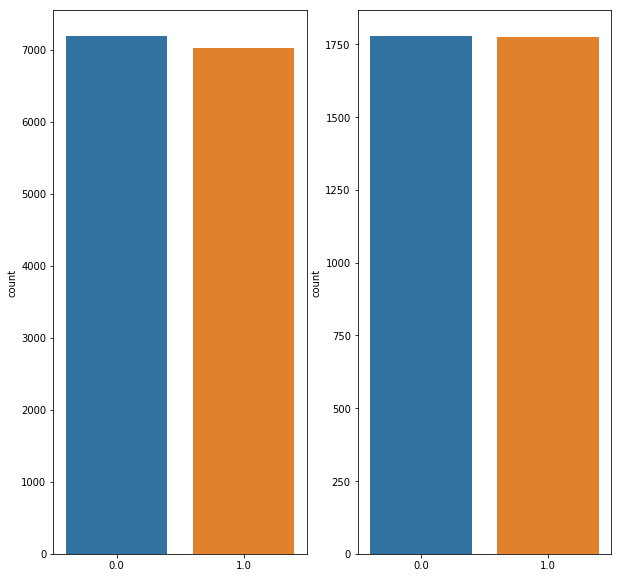

In [35]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.subplot(121)
sns.countplot(y_train)
plt.subplot(122)
sns.countplot(y_test)

In [36]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler # Helpful if we combine multiple methods. For now, it is just HOG.

svc_car = LinearSVC()
svc_car.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [37]:
print('Test Accuracy of SVC = ', round(svc_car.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9797


In [38]:
ystart = 400
ystop = 464

sample = mpimg.imread("test_images/test1.jpg")
sub_img = sample[ystart:ystop, :]
sub_hog = hog(cv2.cvtColor(sub_img, cv2.COLOR_RGB2YUV)[:, :, 1], orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=False)

pix_per_cell = 16 # From the HOG extractor
x_window, y_window = (64, 64)
cells_per_step = 2 # Same step x and y

nxcells = sub_img.shape[1] // pix_per_cell # = 80
nycells = sub_img.shape[0] // pix_per_cell # = 45

cells_per_x_window = x_window // pix_per_cell - 1 # = 3
cells_per_y_window = y_window // pix_per_cell -1 # = 3

nxwindows = (nxcells - cells_per_x_window) // cells_per_step + 1
nywindows = (nycells - cells_per_y_window) // cells_per_step + 1

print(nxcells, nycells, cells_per_x_window, cells_per_y_window, nxwindows, nywindows)

debug = True

rects = []

for y_step in range(nywindows): # This is step number. Have to multiply it with cell_per_step to jump to the correct point.
    for x_step in range(nxwindows):
        y = y_step * cells_per_step
        x = x_step * cells_per_step
        feat = sub_hog[y:(y+cells_per_y_window), x:(x+cells_per_x_window), :, :, :]
        rects.append(((x*pix_per_cell, y*pix_per_cell+ystart), (x*pix_per_cell+x_window, y*pix_per_cell+y_window+ystart)))

80 4 3 3 39 1


In [39]:
print(sample.shape, sub_img.shape, sub_hog.shape)

(720, 1280, 3) (64, 1280, 3) (3, 79, 2, 2, 11)


39


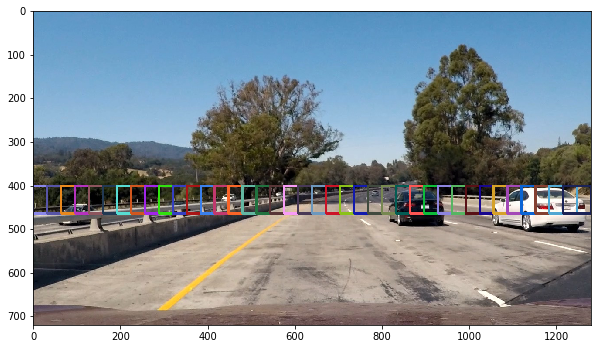

In [40]:
drawn = sample.copy()
for rect in rects:
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    cv2.rectangle(drawn, rect[0], rect[1], color, 3)

plt.figure(figsize=(10,10))
plt.imshow(drawn)

print(len(rects))

In [58]:
def find_cars(img, ystart, ystop, scale, cspace, model, hog_channel='ALL', orient=11, pix_per_cell=16, window=64, cells_per_step=2, cell_per_block=2, debug=False):

    sub_img = img[ystart:ystop, :].astype(np.float32)/255
    
    # Change to desired color space
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(sub_img)   
    print(feature_image.shape)
    # Rescale
    if scale != 1:
        feature_image = cv2.resize(feature_image, (np.int(feature_image.shape[1]/scale), np.int(feature_image.shape[0]/scale)))
    print(feature_image.shape)
    hog_infos = []
    
    # Generate HOG features for the entire sub_image
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]):
            sub_hog = hog(feature_image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                       cells_per_block=(cell_per_block, cell_per_block), feature_vector=False)
            hog_infos.append(sub_hog)
        sub_hog1, sub_hog2, sub_hog3 = hog_infos
    else:
        sub_hog1 = hog(feature_image[:, :, 0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                       cells_per_block=(cell_per_block, cell_per_block), feature_vector=False)
    
    nxcells = feature_image.shape[1] // pix_per_cell # = 80
    nycells = feature_image.shape[0] // pix_per_cell # = 45

    blocks_per_window = (window - pix_per_cell*cell_per_block)/pix_per_cell + 1

    nxwindows = (nxcells - cells_per_x_window) // cells_per_step + 1
    nywindows = (nycells - cells_per_y_window) // cells_per_step + 1
    
    if debug:
        print(nxcells, nycells, cells_per_x_window, cells_per_y_window, nxwindows, nywindows)
                       
    rects = []

    for y_step in range(nywindows): # This is step number. Have to multiply it with cell_per_step to jump to the correct point.
        for x_step in range(nxwindows):
            y = y_step * cells_per_step
            x = x_step * cells_per_step
            print(sub_hog1.shape)
            feat1 = sub_hog1[y:(y+cells_per_y_window), x:(x+cells_per_x_window), :, :, :]
            print(feat1.shape)
            feat2 = sub_hog2[y:(y+cells_per_y_window), x:(x+cells_per_x_window), :, :, :]
            feat3 = sub_hog3[y:(y+cells_per_y_window), x:(x+cells_per_x_window), :, :, :]
            
            test_feats = np.hstack((feat1.ravel(), feat2.ravel(), feat3.ravel()))
            # print(test_feats.shape)
            pred = model.predict(test_feats.reshape(1, -1))
            
            if debug:
                print(test_feats.shape, pred)
            if pred == 1:
                rects.append(((x*pix_per_cell*scale, y*pix_per_cell*scale+ystart), (x*pix_per_cell*scale+x_window*scale, y*pix_per_cell*scale+y_window*scale+ystart)))
   
    return rects                   

Without scaling, `scale = 1`:
* Image shape `(256, 1280, 3)`.
* With `orient=11, cell_per_block=2, pix_per_cell=16`, HOG for 1 layer is `(15, 79, 2, 2, 11)`. Because $(1280-16*2)/16 + 1 = 79$ and $(256-16*2)/16 + 1 = 15$, each block is $16*2$ pixels and next block adjacent to the previous block by 1 cell = 16 pixels.
* Now my window shape is `(64, 64)` which is correspond to $(\frac{64-32}{16}+1, 3, 2, 2, 11)$. Each car crop in the training set is also `(64, 64)`.
* From `(15, 79, 2, 2, 11)` and crop the `(3, 3, 2, 2, 11)` of the appropriate window, 

(256, 1280, 3)
(256, 1280, 3)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(15, 79, 2, 2, 11)
(3, 3, 2, 2, 11)
(1188,)
(1

4


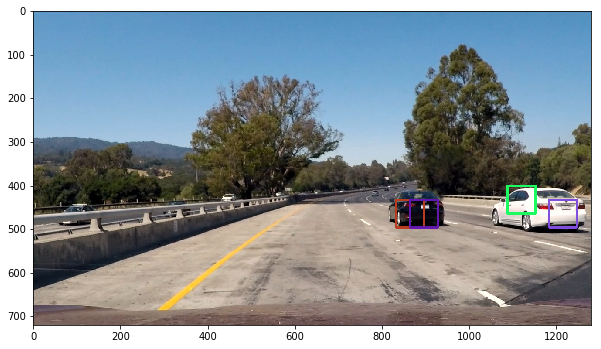

In [60]:
ystart = 400
ystop = 656

sample = mpimg.imread("test_images/test1.jpg")
rects = find_cars(sample, ystart, ystop, 1, 'YUV', svc_car, debug=False)
drawn = sample.copy()
for rect in rects:
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    cv2.rectangle(drawn, rect[0], rect[1], color, 3)

plt.figure(figsize=(10,10))
plt.imshow(drawn)

print(len(rects))

In [28]:
def find_cars_v2(img, ystart, ystop, scale, cspace, model, orient=11, pix_per_cell=16, hog_channel='ALL', window=64, cells_per_step=2, cell_per_block=2, debug=False):
    
    sub_img = img[ystart:ystop, :].astype(np.float32)/255
    
    # Change to desired color space
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(sub_img)   
    
    print(feature_image.shape)
    # Rescale
    if scale != 1:
        feature_image = cv2.resize(feature_image, (np.int(feature_image.shape[1]/scale), np.int(feature_image.shape[0]/scale)))
    print(feature_image.shape)
    hog_infos = []
    
    # Generate HOG features for the entire sub_image
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]):
            sub_hog = hog(feature_image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                       cells_per_block=(cell_per_block, cell_per_block), feature_vector=False)
            hog_infos.append(sub_hog)
        sub_hog1, sub_hog2, sub_hog3 = hog_infos
    else:
        sub_hog1 = hog(feature_image[:, :, 0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                       cells_per_block=(cell_per_block, cell_per_block), feature_vector=False)
    
    # Define blocks and steps as above
    nxblocks = (feature_image.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (feature_image.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
                       
    rects = []

    for y_step in range(nysteps): # This is step number. Have to multiply it with cell_per_step to jump to the correct point.
        for x_step in range(nxsteps):
            y = y_step * cells_per_step
            x = x_step * cells_per_step
            feat1 = sub_hog1[y:(y+nblocks_per_window), x:(x+nblocks_per_window), :, :, :]
            feat2 = sub_hog2[y:(y+nblocks_per_window), x:(x+nblocks_per_window), :, :, :]
            feat3 = sub_hog3[y:(y+nblocks_per_window), x:(x+nblocks_per_window), :, :, :]
            
            test_feats = np.hstack((feat1.ravel(), feat2.ravel(), feat3.ravel()))
            pred = model.predict(test_feats.reshape(1, -1))
            
            if debug:
                print(test_feats.shape, pred)
            if pred == 1:
                rects.append(((np.int(x*pix_per_cell*scale), np.int(y*pix_per_cell*scale+ystart)), (np.int(x*pix_per_cell*scale+x_window*scale), np.int(y*pix_per_cell*scale+y_window*scale+ystart))))
   
    return rects                   

(256, 1280, 3)
(170, 853, 3)
4


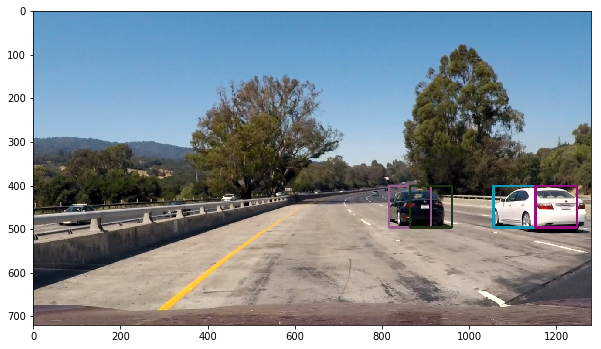

In [50]:
ystart = 400
ystop = 656

sample = mpimg.imread("test_images/test1.jpg")
rects = find_cars_v2(sample, ystart, ystop, 1.5, 'YUV', svc_car)
drawn = sample.copy()
for rect in rects:
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    cv2.rectangle(drawn, rect[0], rect[1], color, 3)

plt.figure(figsize=(10,10))
plt.imshow(drawn)

print(len(rects))

- Experiment with different HOG parameters
- Get the color histograms
- Experiment with different parameters
- heatmap()
- Fit to videoframe